# Robustness in marker gene selection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.gridspec as grid_spec
import lzma

In [2]:
from scipy.stats import pmean

In [3]:
import seaborn as sns

In [4]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

## Functions

In [5]:
def adjMatv2(edges_ogs, edges_genomes):
    # Get unique elements
    ogs, ogs_indices = np.unique(edges_ogs, return_inverse = True)
    genomes, genomes_indices = np.unique(edges_genomes, return_inverse = True)
    # Calculate bin counts for each combination of indices
    counts = np.bincount(ogs_indices * len(genomes) + genomes_indices, minlength = len(ogs) * len(genomes))
    # Reshape counts as adjacency matrix
    adj = counts.reshape(len(ogs), len(genomes))
    return adj, genomes, ogs

In [6]:
def save_genes(genes, fOut):
    with open(fOut, 'w') as f:
        for gene in genes:
            f.write(f'{gene}\n')

In [7]:
def remove_genes(adj_mod):
    '''
    Function that removes genes if:
        present in less than 4 genomes/species
    '''
    remove = np.array([i for i in range(len(adj_mod)) if adj_mod[i].sum() < 4])
    return remove

In [8]:
def greedy_power_mean_sample_final(data, k, p, pseudocount, min_universality_genes):
    """Select k rows from a matrix such that the selection criterion by column is maximized.

    Parameters
    ----------
    data : ndarray (2D)
        Input data matrix.
    k : int
        Number of rows to select.
    p : float
        Exponent.

    Returns
    -------
    ndarray (1D)
        Row indices selected in order.
    """

    n, m = data.shape

    # Matrix is empty
    if n == 0 or m == 0:
        raise ValueError(f'Matrix is empty!')

    # Matrix contains only zeroes
    if (data == 0).all():
        raise ValueError(f'Matrix only contains 0\'s')

    if (data.sum(axis = 1) == min_universality_genes).all():
        raise ValueError(f'Matrix only contains genes present in less than {min_universality_genes}')

    if k >= n:
        raise ValueError(f'k should be smaller than {n}')
    
    # Add pseudocount
    data = data + pseudocount

    # cumulative gene counts
    counts = np.zeros(m, dtype = int)

    # gene indices in original data matrix
    indices = np.arange(n)

    # indices of selected genes
    selected = []

    # will select k genes sequentially
    for i in range(k):
        # calculate counts after adding each gene
        sums_ = counts + data

        # select a gene that maximizes the power mean gene count per genome, using the cumulative matric
        if isinstance(p, int) or isinstance(p, np.int64): 
            choice = pmean(sums_, int(p), axis = 1).argmax()
        elif p == 'min':
            choice = sums_.min(axis = 1).argmax()
        elif p == 'max':
            choice = sums_.max(axis = 1).argmax()
        else:
            raise ValueError(f'Invalid p: {p}.')

        # append index of selected gene
        selected.append(indices[choice])

        # update per-species gene counts
        counts = sums_[choice]

        # remove selected gene from data matrix
        data = np.delete(data, choice, axis = 0)

        # remove selected gene from indices
        indices = np.delete(indices, choice)

    return np.sort(np.array(selected))

### EggNog -- raw data

In [9]:
# %%time
# tmp = []
# with lzma.open(f'./input_data/emapper.annotations.xz', mode = 'rt') as f:
#     for i, line in enumerate(f):
#         row = line.strip().split('\t')
#         orf, score, og = row[0], row[3], row[4].split('|')[0]
#         genome = orf.split('_')[0]
#         tmp.append([orf, float(score), og.split('@')[0], genome])

In [10]:
# len(tmp)

In [11]:
# df_eggnog = pd.DataFrame(tmp, columns = ['orf', 'score', 'og', 'genome'])
# df_eggnog.set_index('orf', inplace = True)

In [12]:
# df_eggnog.shape

In [13]:
# df_eggnog.head()

## KEGG --raw data

In [14]:
# %%time
# tmp = []
# with lzma.open(f'./input_data/kofamscan.tsv.xz', mode = 'rt') as f:
#     for line in f:
#         row = line.strip().split('\t')
#         # print(row)
#         orf, ko, score = row[0], row[1], row[3]
#         genome = orf.split('_')[0]
#         tmp.append([orf, float(score), ko, genome])

In [15]:
# len(tmp)

In [16]:
# df_kegg = pd.DataFrame(tmp, columns = ['orf', 'score', 'ko', 'genome'])
# df_kegg.set_index('orf', inplace = True)

In [17]:
# df_kegg.shape

For each genome and gene, discard those genes with a score less than `x` of the top `score`

In [18]:
# %%time
# threshold = 1.0
# # Calculate the maximum score for each genome and pfam combination
# max_scores = df_kegg.groupby(['genome', 'ko'])['score'].transform('max')
# # Keep rows where the score is greater than or equal to max_score * threshold
# filtered_df = df_kegg[df_kegg['score'] >= max_scores * threshold]

In [19]:
# filtered_df.shape

In [20]:
# edges_genomes = filtered_df['genome'].values
# edges_ogs = filtered_df['ko'].values

In [21]:
# print(f'Genomes: {len(edges_genomes)}')
# print(f'OGs: {len(edges_ogs)}')

### Build presence-absence matrix

In [22]:
# %%time
# adj, genomes, ogs = adjMatv2(edges_ogs, edges_genomes)
# adj.shape

In [23]:
# genomes.shape

In [24]:
# ogs.shape

In [25]:
# genomes_indices = np.arange(len(genomes))
# genomes_indices.shape

Randomly sample 1,000 species/genomes across 25 replicates

In [26]:
# replicates = np.arange(25)
# selected_genes_mod = {}

In [27]:
# %%time
# for rep in replicates:
#     print(f'Replicate: {rep}')
#     rng = np.random.default_rng(rep)
#     genomes_sampled_indices = np.sort(rng.choice(genomes_indices, size = 1000, replace = False))
#     # Reformat copy number matrix
#     adj1 = adj.copy()
#     adj1 = adj1[:, genomes_sampled_indices]
#     # Contains copy numbers
#     adj2 = adj1.copy()
#     adj1[adj1 > 1] = 1
#     # Remove species in less than 4 genomes
#     # Copy presence/absence matrix
#     adj_mod = adj1
#     # Select genes to remove
#     remove = remove_genes(adj_mod)
#     # Remove genes
#     adj_mod = np.delete(adj_mod, remove, axis = 0)
#     # Remove genes from list
#     ogs_mod = np.delete(ogs, remove, axis = 0)
#     # Copy matrix
#     adj_mod2 = adj2
#     # Remove genes
#     adj_mod2 = np.delete(adj_mod2, remove, axis = 0)
#     print(f'\tShape of copy number matrix: {adj_mod2.shape}')
#     # Marker gene selection
#     k = 400
#     # ps = [0, -1, -2, -5, -10]
#     ps = [10, 5, 2, 1]
#     # Iterate over number of selected genes
#     selected_genes_mod[rep] = {}
#     # Iterate over criteria
#     for p in ps:
#         select = greedy_power_mean_sample_final(adj_mod2, k, p = p, pseudocount = 0.1, min_universality_genes = 1)
#         selected_genes_mod[rep][p] = [ogs_mod[i] for i in select]

In [28]:
# for rep, data in selected_genes_mod.items():
#     with open(f'./output_data/wol2/marker_genes/kegg/robustness_sampling_rep_{rep}.txt', 'w') as f:
#     with open(f'./output_data/wol2/marker_genes/eggnog/robustness_sampling_rep_{rep}.txt', 'w') as f:
#         for p, genes in data.items():
#             f.write(f'presence_absence_copies_k_{k}_p_{p}\n')
#             for gene in genes:
#                 f.write(f'{gene}\n')

## Results

In [29]:
def loadMarkerGenes(fIn):
    marker_genes = {}
    with open(fIn, 'r') as f:
        for line in f:
            if 'presence' in line.strip():
                header = line.strip()
                marker_genes[header] = []
            else:
                gene = line.strip()
                marker_genes[header].append(gene)
                
    return marker_genes

In [30]:
replicates = np.arange(25)

### KEGG

In [31]:
%%time
marker_genes_replicates_kegg = {}
for rep in replicates:
    marker_genes_replicates_kegg[rep] = loadMarkerGenes(f'./output_data/wol2/marker_genes/kegg/sampling_genomes/robustness_sampling_rep_{rep}.txt')

CPU times: user 21 ms, sys: 6.64 ms, total: 27.6 ms
Wall time: 33 ms


In [32]:
counts_kegg = {k : {} for k in marker_genes_replicates_kegg[0].keys()}

Count the number of times each gene has been selected

In [33]:
%%time
for rep, data in marker_genes_replicates_kegg.items():
    for condition, genes in data.items():
        for gene in genes:
            if gene not in counts_kegg[condition].keys():
                counts_kegg[condition][gene] = 1
            else:
                counts_kegg[condition][gene] += 1

CPU times: user 23.4 ms, sys: 1.14 ms, total: 24.5 ms
Wall time: 24.7 ms


Convert dictionary into dataframe

In [34]:
df_counts_kegg = pd.DataFrame(counts_kegg).fillna(0)

In [35]:
df_counts_kegg.shape

(1082, 5)

Heatmap

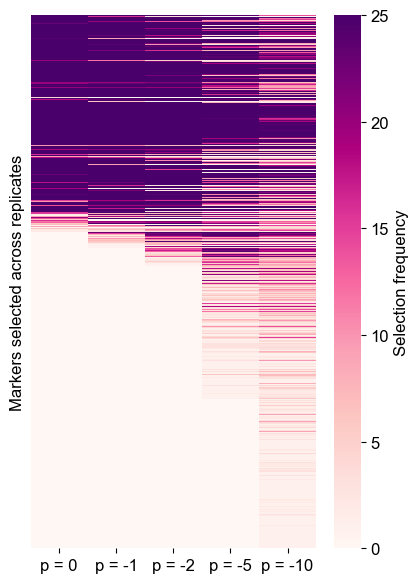

In [36]:
plt.figure(figsize = (4.15, 6))
sns.heatmap(df_counts_kegg, cbar_kws = { 'label': 'Selection frequency'},
           cmap = 'RdPu', xticklabels = ['p = 0', 'p = -1', 'p = -2', 'p = -5', 'p = -10'],
           yticklabels = [], )
plt.tight_layout()
plt.ylabel('Markers selected across replicates')
plt.savefig(f'./figures/figure_S4B_heatmap_kegg.svg')
plt.show()

Total number of genes selected in each condition

In [37]:
total_number_kegg = []
for column in df_counts_kegg.columns:
    total_number_kegg.append(len(df_counts_kegg[df_counts_kegg[column] != 0][column]))

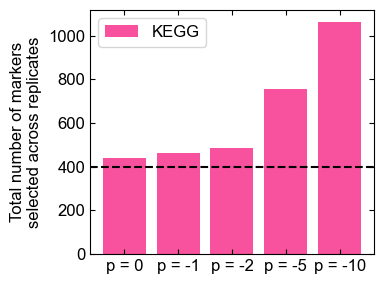

In [38]:
plt.figure(figsize = (4, 3))
x = np.arange(len(total_number_kegg))
plt.bar(x, total_number_kegg, color = '#f72585', alpha = 0.8, label = 'KEGG')
plt.axhline(y = 400, ls = 'dashed', color = 'k')
plt.xticks(x, ['p = 0', 'p = -1', 'p = -2', 'p = -5', 'p = -10'])
# plt.xticks(x, [10, 5, 2, 1, 0, -1, -2, -5, -10])
plt.ylabel('Total number of markers\nselected across replicates')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.legend()
plt.show()

Jaccard similarity index of all genes selected in each condition ($p$)

In [39]:
from functools import reduce

In [40]:
tmp = {}
for rep, data in marker_genes_replicates_kegg.items():
    for condition, markers in data.items():
        if condition not in tmp:
            tmp[condition] =  [markers]
        else:
            tmp[condition].append(markers)

In [41]:
jaccard_kegg = []
for condition, all_markers in tmp.items():
    union = len(set(reduce(lambda x, y: set(x) | set(y), tmp[condition])))
    intersection = len(set(reduce(lambda x, y: set(x) & set(y), tmp[condition])))
    jaccard_kegg.append(intersection / union)

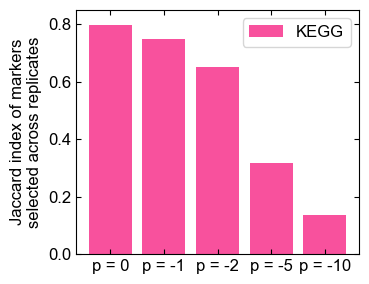

In [42]:
plt.figure(figsize = (3.85, 3))
x = np.arange(len(jaccard_kegg))
plt.bar(x, jaccard_kegg, color = '#f72585', alpha = 0.8, label = 'KEGG')
# plt.axhline(y = 400, ls = 'dashed', color = 'k')
plt.xticks(x, ['p = 0', 'p = -1', 'p = -2', 'p = -5', 'p = -10'])
# plt.xticks(x, [10, 5, 2, 1, 0, -1, -2, -5, -10])
plt.ylabel('Jaccard index of markers\nselected across replicates')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.legend()
plt.ylim(0, 0.85)
plt.savefig(f'./figures/figure_S4B_jaccard_kegg.svg')
plt.show()

## EggNog

In [43]:
%%time
marker_genes_replicates_eggnog = {}
for rep in replicates:
    marker_genes_replicates_eggnog[rep] = loadMarkerGenes(f'./output_data/wol2/marker_genes/eggnog/sampling_genomes/robustness_sampling_rep_{rep}.txt')

CPU times: user 21 ms, sys: 5.56 ms, total: 26.5 ms
Wall time: 28.8 ms


In [44]:
counts_eggnog = {k : {} for k in marker_genes_replicates_eggnog[0].keys()}

In [45]:
%%time
for rep, data in marker_genes_replicates_eggnog.items():
    for condition, genes in data.items():
        for gene in genes:
            if gene not in counts_eggnog[condition].keys():
                counts_eggnog[condition][gene] = 1
            else:
                counts_eggnog[condition][gene] += 1

CPU times: user 23.3 ms, sys: 1.92 ms, total: 25.3 ms
Wall time: 25.4 ms


In [46]:
df_counts_eggnog = pd.DataFrame(counts_eggnog).fillna(0)

In [47]:
df_counts_eggnog.shape

(772, 5)

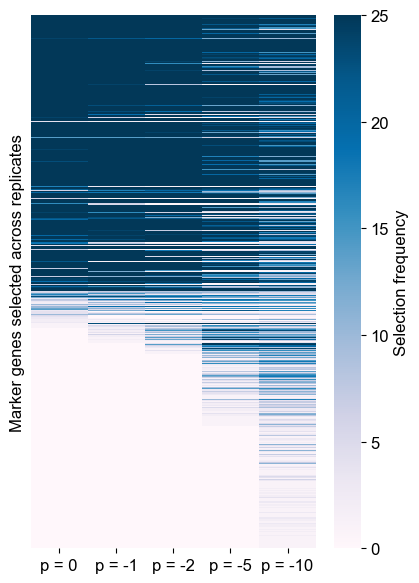

In [48]:
plt.figure(figsize = (4.15, 6))
sns.heatmap(df_counts_eggnog, cbar_kws = { 'label': 'Selection frequency'},
           cmap = 'PuBu', xticklabels = ['p = 0', 'p = -1', 'p = -2', 'p = -5', 'p = -10'],
           yticklabels = [], )
plt.tight_layout()
plt.ylabel('Marker genes selected across replicates')
plt.savefig(f'./figures/figure_S4B_heatmap_kegg.svg')
plt.show()

In [49]:
total_number_eggnog = []
for column in df_counts_eggnog.columns:
    total_number_eggnog.append(len(df_counts_eggnog[df_counts_eggnog[column] != 0][column]))

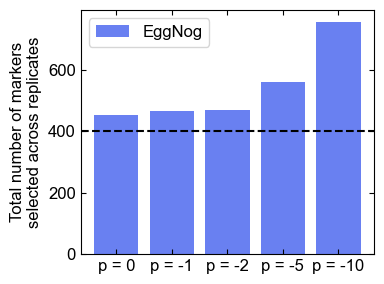

In [50]:
plt.figure(figsize = (4, 3))
x = np.arange(len(total_number_eggnog))
plt.bar(x, total_number_eggnog, color = '#4361ee', alpha = 0.8, label = 'EggNog')
plt.axhline(y = 400, ls = 'dashed', color = 'k')
plt.xticks(x, ['p = 0', 'p = -1', 'p = -2', 'p = -5', 'p = -10'])
plt.ylabel('Total number of markers\nselected across replicates')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.legend()
plt.show()

Jaccard similarity index of all genes selected in each condition ($p$)

In [51]:
tmp = {}
for rep, data in marker_genes_replicates_eggnog.items():
    for condition, markers in data.items():
        if condition not in tmp:
            tmp[condition] =  [markers]
        else:
            tmp[condition].append(markers)

In [52]:
jaccard_eggnog = []
for condition, all_markers in tmp.items():
    union = len(set(reduce(lambda x, y: set(x) | set(y), tmp[condition])))
    intersection = len(set(reduce(lambda x, y: set(x) & set(y), tmp[condition])))
    jaccard_eggnog.append(intersection / union)

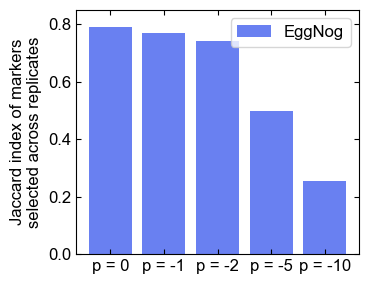

In [53]:
plt.figure(figsize = (3.85, 3))
x = np.arange(len(jaccard_eggnog))
plt.bar(x, jaccard_eggnog, color = '#4361ee', alpha = 0.8, label = 'EggNog')
# plt.axhline(y = 400, ls = 'dashed', color = 'k')
plt.xticks(x, ['p = 0', 'p = -1', 'p = -2', 'p = -5', 'p = -10'])
plt.ylabel('Jaccard index of markers\nselected across replicates')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.legend()
plt.ylim(0, 0.85)
plt.savefig(f'./figures/figure_S4B_jaccard_eggnog.svg')
plt.show()